In [1]:
import os
import pandas as pd
import numpy as np
import time, gc
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pretrainedmodels
from argparse import Namespace
from sklearn.utils import shuffle
from apex import amp

In [2]:
!ls /home/chec/data/bengali

class_map.csv		       train.csv
sample_submission.csv	       train.csv.zip
test.csv		       train_image_data_0.parquet
test_image_data_0.parquet      train_image_data_0.parquet.zip
test_image_data_0.parquet.zip  train_image_data_1.parquet
test_image_data_1.parquet      train_image_data_1.parquet.zip
test_image_data_1.parquet.zip  train_image_data_2.parquet
test_image_data_2.parquet      train_image_data_2.parquet.zip
test_image_data_2.parquet.zip  train_image_data_3.parquet
test_image_data_3.parquet      train_image_data_3.parquet.zip
test_image_data_3.parquet.zip


In [3]:
DATA_DIR = '/home/chec/data/bengali'

In [4]:
train_df = pd.read_csv(f'{DATA_DIR}/train.csv')
test_df = pd.read_csv(f'{DATA_DIR}/test.csv')
class_map_df = pd.read_csv(f'{DATA_DIR}/class_map.csv')
sample_sub_df = pd.read_csv(f'{DATA_DIR}/sample_submission.csv')

In [5]:
train_df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [6]:
train_df.shape

(200840, 5)

In [7]:
len(train_df.image_id.unique())

200840

In [8]:
train_df.grapheme_root.value_counts()

72     5736
64     5596
13     5420
107    5321
23     5149
96     4926
113    4395
147    4392
133    4374
115    4015
53     3690
43     3630
103    3461
79     3458
81     3438
38     3354
159    3281
22     2961
71     2936
29     2780
56     2688
149    2402
59     2339
89     2313
122    2313
139    2312
150    2311
124    2188
86     2094
123    2073
       ... 
146     302
78      293
82      292
37      285
19      278
34      276
5       175
26      171
87      168
163     165
164     164
104     160
126     159
108     158
8       157
7       153
10      152
105     151
11      151
114     150
63      149
0       147
12      146
1       145
45      144
130     144
158     143
102     141
33      136
73      130
Name: grapheme_root, Length: 168, dtype: int64

In [9]:
df = pd.read_parquet(f'{DATA_DIR}/train_image_data_0.parquet')
df.head()

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255


In [10]:
df.shape

(50210, 32333)

In [11]:
df2 = df.set_index('image_id')

In [12]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
image_id,,,,,,,,,,,,,,,,,,,,,
Train_0,254,253,252,253,251,252,253,251,251,253,...,253,253,253,253,253,253,253,253,253,251
Train_1,251,244,238,245,248,246,246,247,251,252,...,255,255,255,255,255,255,255,255,255,254
Train_2,251,250,249,250,249,245,247,252,252,252,...,254,253,252,252,253,253,253,253,251,249
Train_3,247,247,249,253,253,252,251,251,250,250,...,254,254,254,254,254,253,253,252,251,252
Train_4,249,248,246,246,248,244,242,242,229,225,...,255,255,255,255,255,255,255,255,255,255


In [13]:
df2.index

Index(['Train_0', 'Train_1', 'Train_2', 'Train_3', 'Train_4', 'Train_5',
       'Train_6', 'Train_7', 'Train_8', 'Train_9',
       ...
       'Train_50200', 'Train_50201', 'Train_50202', 'Train_50203',
       'Train_50204', 'Train_50205', 'Train_50206', 'Train_50207',
       'Train_50208', 'Train_50209'],
      dtype='object', name='image_id', length=50210)

In [14]:
HEIGHT = 137
WIDTH = 236

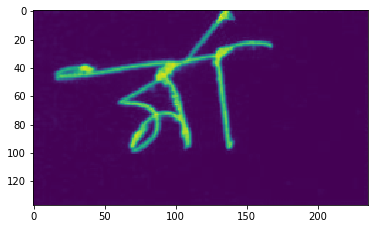

In [15]:
img = 255 - df.iloc[10, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
plt.imshow(img)

In [16]:
#img2 = cv2.resize(img, (256, 128))
#plt.imshow(img2)

In [25]:
img.shape

(137, 236)

In [38]:
HEIGHT = 137
WIDTH = 236

CROP_SIZE = 224

def crop_and_resize_images(df, resized_df, resize_size = CROP_SIZE):
    cropped_imgs = {}
    for img_id in tqdm(range(df.shape[0])):
        img = resized_df[img_id]
        _, thresh = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
        
        idx = 0 
        ls_xmin = []
        ls_ymin = []
        ls_xmax = []
        ls_ymax = []
        for cnt in contours:
            idx += 1
            x,y,w,h = cv2.boundingRect(cnt)
            ls_xmin.append(x)
            ls_ymin.append(y)
            ls_xmax.append(x + w)
            ls_ymax.append(y + h)
        xmin = min(ls_xmin)
        ymin = min(ls_ymin)
        xmax = max(ls_xmax)
        ymax = max(ls_ymax)

        roi = img[ymin:ymax,xmin:xmax]
        resized_roi = cv2.resize(roi, (resize_size, resize_size))
        cropped_imgs[df.image_id[img_id]] = resized_roi.reshape(-1)
        
    resized = pd.DataFrame(cropped_imgs).T.reset_index()
    resized.columns = resized.columns.astype(str)
    resized.rename(columns={'index':'image_id'},inplace=True)
    return resized #out_df

def crop_and_resize_image(img, resize_size = CROP_SIZE):
        _, thresh = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
        
        idx = 0 
        ls_xmin = []
        ls_ymin = []
        ls_xmax = []
        ls_ymax = []
        for cnt in contours:
            idx += 1
            x,y,w,h = cv2.boundingRect(cnt)
            ls_xmin.append(x)
            ls_ymin.append(y)
            ls_xmax.append(x + w)
            ls_ymax.append(y + h)
        xmin = min(ls_xmin)
        ymin = min(ls_ymin)
        xmax = max(ls_xmax)
        ymax = max(ls_ymax)

        roi = img[ymin:ymax,xmin:xmax]
        resized_roi = cv2.resize(roi, (resize_size, resize_size))
        
        return resized_roi

In [70]:
def show_crop(idx):
    img = 255 - df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)

    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 15))
    ax0.imshow(img, cmap='Greys')
    ax0.set_title('Original image')
    ax1.imshow(crop_and_resize_image(img), cmap='Greys')
    ax1.set_title('crop_and_resize_image image')
    ax2.imshow(crop_resize(img, pad=0), cmap='Greys')
    ax2.set_title('crop_resize image')
    plt.show()

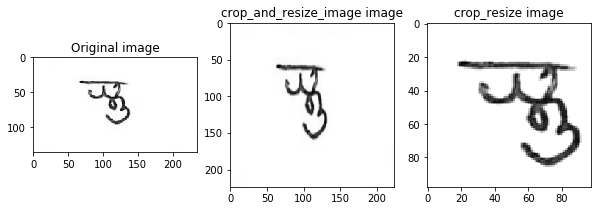

In [77]:
show_crop(10003)

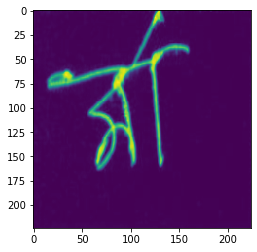

In [59]:
img = 255 - df.iloc[10, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)

plt.imshow(crop_and_resize_image(img))

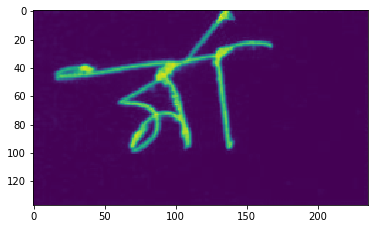

In [60]:
plt.imshow(img)

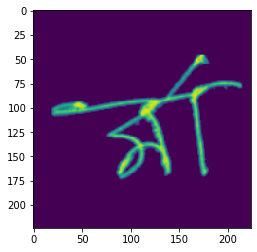

In [61]:
plt.imshow(crop_resize(img, pad=0))

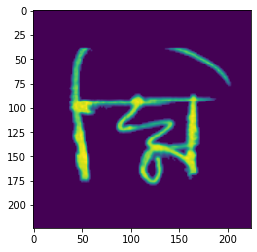

In [58]:
plt.imshow(crop_resize(img, pad=16))

In [74]:
HEIGHT = 137
WIDTH = 236
SIZE = 224
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    
    return img
    #return cv2.resize(img,(size,size))

In [17]:
import albumentations as albu

def get_train_augs(p=1.):
    return albu.Compose([
        #albu.HorizontalFlip(.5),
        albu.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5 ),
        albu.Blur(blur_limit=3, p=0.3),
        albu.OpticalDistortion(p=0.3),
        albu.GaussNoise(p=0.3)
        #albu.GridDistortion(p=.33),
        #albu.HueSaturationValue(p=.33) # not for grey scale
    ], p=p)

In [18]:
augs = get_train_augs(1.0)

In [19]:
img.shape

(137, 236)

In [20]:
#x=augs(image=img)['image']

In [21]:
#plt.imshow(x)

In [22]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

HEIGHT = 137
WIDTH = 236

class BengaliDataset(Dataset):
    def __init__(self, df, img_df, train_mode=True, test_mode=False):
        self.df = df
        self.img_df = img_df
        self.train_mode = train_mode
        self.test_mode = test_mode

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = self.get_img(row.image_id)
        #print(img.shape)
        if self.train_mode:
            augs = get_train_augs()
            img = augs(image=img)['image']
        
        img = np.expand_dims(img, axis=-1)
        
        img = transforms.functional.to_tensor(img)
        #img = transforms.functional.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        if self.test_mode:
            return img
        else:
            return img, torch.tensor([row.grapheme_root, row.vowel_diacritic, row.consonant_diacritic])

    def get_img(self, img_id):
        return 255 - self.img_df.loc[img_id].values.reshape(HEIGHT, WIDTH).astype(np.uint8)

    def __len__(self):
        return len(self.df)
    
def get_train_val_loaders(batch_size=4, val_batch_size=4, dev_mode=False):
    train_df = pd.read_csv(f'{DATA_DIR}/train.csv')
    train_df = shuffle(train_df, random_state=1234)
    print(train_df.shape)

    if dev_mode:
        img_df = pd.read_parquet(f'{DATA_DIR}/train_image_data_0.parquet').set_index('image_id')
        train_df = train_df.iloc[:1000]
    else:
        img_dfs = [pd.read_parquet(f'{DATA_DIR}/train_image_data_{i}.parquet') for i in range(4)]
        img_df = pd.concat(img_dfs, axis=0).set_index('image_id')
    print(img_df.shape)
    split_index = int(len(train_df) * 0.9)
    
    train = train_df.iloc[:split_index]
    val = train_df.iloc[split_index:]
    print(train.shape, val.shape)
    
    train_ds = BengaliDataset(train, img_df, True, False)
    val_ds = BengaliDataset(val, img_df, False, False)
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)
    train_loader.num = len(train_ds)

    val_loader = DataLoader(val_ds, batch_size=val_batch_size, shuffle=False, num_workers=8, drop_last=False)
    val_loader.num = len(val_ds)

    return train_loader, val_loader

In [23]:
#train_loader, val_loader = get_train_val_loaders(dev_mode=True)

In [24]:
'''
for img, y in train_loader:
    print(img.size(), y.size())
    print(y)
    #print(img)
    #plt.imshow(img.squeeze()[0].numpy())
    break
'''

'\nfor img, y in train_loader:\n    print(img.size(), y.size())\n    print(y)\n    #print(img)\n    #plt.imshow(img.squeeze()[0].numpy())\n    break\n'